In [1]:
import os
import time
import re

In [2]:
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [3]:
import utils
from transformer_net import TransformerNet
from vgg import Vgg16

<br>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
bs = 16

In [6]:
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

In [7]:
train_dataset = datasets.ImageFolder('images/dataset/train/', image_transform)
train_dataloader = DataLoader(train_dataset, batch_size=bs)

val_dataset = datasets.ImageFolder('images/dataset/val/')
val_dataloader = DataLoader(val_dataset, batch_size=bs)

In [8]:
transformer = TransformerNet().to(device)
optimizer = Adam(transformer.parameters(), lr=0.001)
mse_loss = torch.nn.MSELoss()

In [9]:
vgg = Vgg16(requires_grad=False).to(device)

In [10]:
style = utils.load_image('images/style_images/mosaic.jpg', size=256)

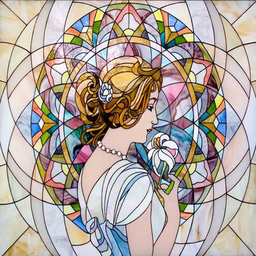

In [11]:
style

In [12]:
style = style_transform(style)

In [13]:
style = style.repeat(bs, 1,1,1).to(device)

In [14]:
features_style = vgg(utils.normalize_batch(style))

In [15]:
gram_style = [utils.gram_matrix(y) for y in features_style]

In [16]:
def train(epochs=2, content_weight=1e5, style_weight=1e10, loss_tracker=None):
    time0 = time.time()
    for e in range(epochs):
        
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count =0

        for batch_idx, (x, _) in enumerate (train_dataloader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = utils.normalize_batch(y)
            x = utils.normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * mse_loss(features_y.relu2_2,
                                                     features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = utils.gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()
            
            if loss_tracker is not None:
                loss_tracker.append(total_loss.item())

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_idx + 1) % 50 == 0:
                message = ("{:d}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                           int(time.time() - time0), e + 1, count, len(train_dataset),
                           agg_content_loss / (batch_idx + 1),
                           agg_style_loss / (batch_idx + 1),
                           (agg_content_loss + agg_style_loss) / (batch_idx + 1)))
                print(message)


In [17]:
loss_tracker = []
train(loss_tracker=loss_tracker)

90	Epoch 1:	[800/82783]	content: 913189.507500	style: 35424291.200000	total: 36337480.707500
182	Epoch 1:	[1600/82783]	content: 1088522.921250	style: 30229950.760000	total: 31318473.681250
276	Epoch 1:	[2400/82783]	content: 1285635.200833	style: 25367291.480000	total: 26652926.680833
368	Epoch 1:	[3200/82783]	content: 1433885.938750	style: 21716600.125000	total: 23150486.063750
461	Epoch 1:	[4000/82783]	content: 1544284.543500	style: 18951032.500000	total: 20495317.043500
556	Epoch 1:	[4800/82783]	content: 1628920.547917	style: 16780774.283333	total: 18409694.831250
649	Epoch 1:	[5600/82783]	content: 1697309.847500	style: 15027831.567857	total: 16725141.415357
743	Epoch 1:	[6400/82783]	content: 1754632.739375	style: 13592434.994375	total: 15347067.733750
839	Epoch 1:	[7200/82783]	content: 1801828.871111	style: 12400788.900556	total: 14202617.771667
932	Epoch 1:	[8000/82783]	content: 1842920.142000	style: 11401874.389000	total: 13244794.531000
1025	Epoch 1:	[8800/82783]	content: 1876825

KeyboardInterrupt: 

In [18]:
transformer.eval().cpu()
torch.save(transformer.state_dict(), 'saved_models/model_#1.model')

In [28]:
def stylize(model, output_file, scale=None):
    
    content_image = utils.load_image('images/content_images/amber.jpg', scale=scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        style_model = TransformerNet()
        state_dict = torch.load(model)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
        
        style_model.load_state_dict(state_dict)
        style_model.to(device)
        
        output = style_model(content_image).cpu()
        utils.save_image(output_file, output[0])

In [29]:
stylize('saved_models/model_#1.model', 'images/output_1.png')

In [42]:
image = utils.load_image('images/output_1.png', size=512)

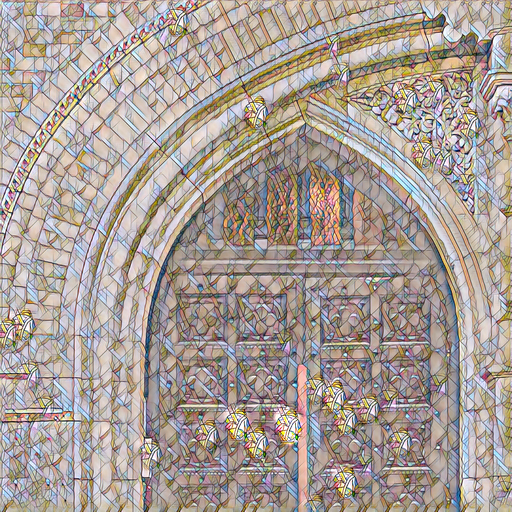

In [43]:
image

In [46]:
import matplotlib.pyplot as plt

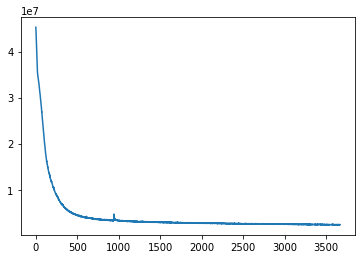

In [47]:
plt.plot(loss_tracker)